In [1]:
from google.colab import drive
# mount drive to access data
drive.mount('/content/drive')
# load data folder into working directory
!cp -r drive/MyDrive/data .

Mounted at /content/drive


### Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from itertools import compress
import numpy as np
import math
from tqdm import tqdm

In [3]:
# loading raw data
raw_data = pd.read_csv('data/TweetsCOV19.csv')
# loading data with preprocessed tweets
data = pd.read_csv('data/cleaned_tweets.csv')

<ipython-input-3-c7ef6bf0cdf3>:2: DtypeWarning: Columns (0,1) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_data = pd.read_csv('data/TweetsCOV19.csv')


In [4]:
# tokenize the preprocessed tweets
tokenized_tweets = data['TweetText'].tolist()
for i, tweet in enumerate(tokenized_tweets):
  tokenized_tweets[i] = tweet.split()

### Unigram, Bigram Distribution

In [5]:
# returns ngrams, ordered by frequency
def ngram_freq(tweets, n):

    ngrams = dict()

    for tweet in tqdm(tweets):
        for i in range(len(tweet)-n + 1):
            if tuple(tweet[i:i+n]) in ngrams:
                ngrams[tuple(tweet[i:i+n])] += 1
            else:
                ngrams[tuple(tweet[i:i+n])] = 1

    ngrams = sorted(ngrams.items(), key=lambda x:-x[1])

    return ngrams

In [6]:
# remove nans from raw_data
raw_data = raw_data[raw_data['TweetText'].notnull()]

In [7]:
# turn tweets into words
raw_tweets = raw_data['TweetText'].tolist()
for i, tweet in enumerate(raw_tweets):
  raw_tweets[i] = tweet.split()

In [8]:
# get most frequent unigrams and bigrams
unigrams = ngram_freq(tokenized_tweets, 1)
raw_unigrams = ngram_freq(raw_tweets, 1)
bigrams = ngram_freq(tokenized_tweets, 2)
raw_bigrams = ngram_freq(raw_tweets, 2)

100%|██████████| 675370/675370 [00:24<00:00, 27653.20it/s]


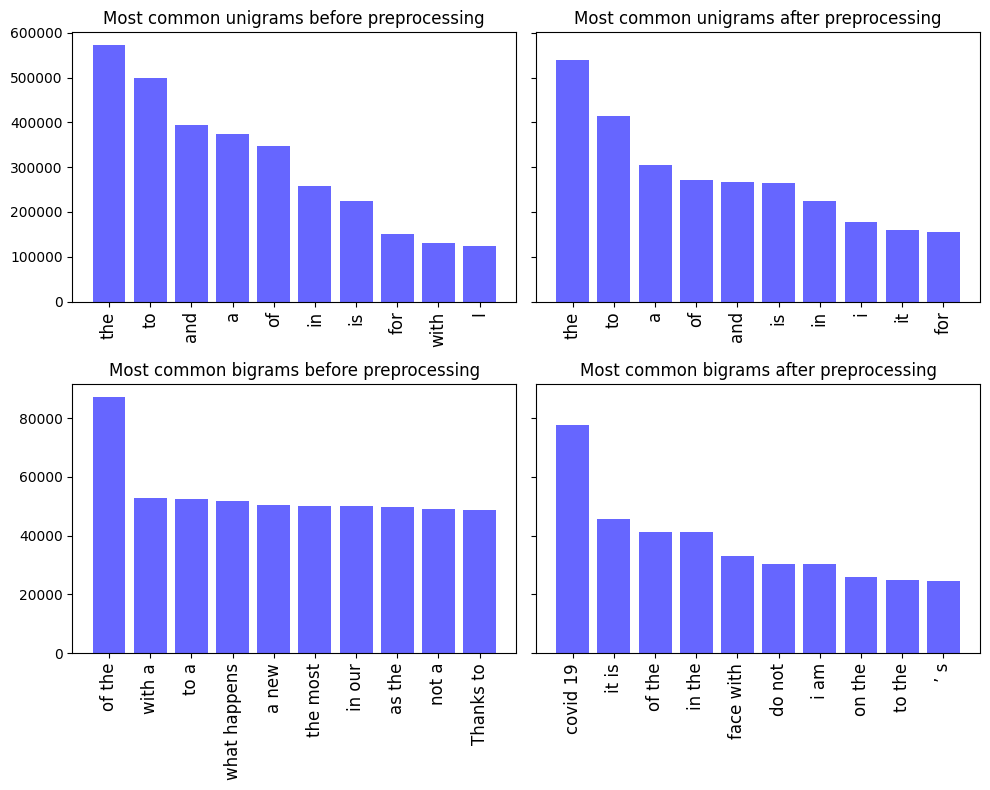

In [9]:
# plot unigram, bigram frequency before and after preprocessing 
fig, ax = plt.subplots(2, 2, sharey='row', figsize=(10,8))

titles = ['Most common unigrams before preprocessing', \
          'Most common unigrams after preprocessing', \
          'Most common bigrams before preprocessing', \
          'Most common bigrams after preprocessing']
grams = [raw_unigrams, unigrams, raw_bigrams, bigrams]
pos = [i for i in range(10)] # position of bars

for i, (title, gram) in enumerate(zip(titles, grams)):

    words = [gram[j][0][0] for j in range(10)]
    if i > 1:
        words = [' '.join(gram[j][0]) for j in range(10)]
    freq = [gram[j][1] for j in range(10)]

    ax[i//2][i % 2].bar(pos, freq, align='center', color='b', alpha=0.6)
    ax[i//2][i % 2].set_xticks(pos)
    ax[i//2][i % 2].set_xticklabels(words, fontsize=12, rotation='vertical')
    ax[i//2][i % 2].set_title(title, fontsize=12)

plt.tight_layout()
plt.savefig("uni-bigram-frequencies.png")
plt.show()

### Unigram, Bigram Distribution as function of sentiment

In [10]:
def get_tweets_by_sentiment(data):

  sentiments = data['Sentiment'].tolist()
  # split into positive and negative sentiments
  positive = []
  negative = []

  for s in sentiments:
    p, n = s.split()
    p = int(p)
    n = int(n)
    positive.append(p)
    negative.append(n)

  # select very positive, very negative and neutral sentiments
  pos_five = [x == 5 or x == 4 for x in positive]
  neg_five = [x == -5 or x == -4 for x in negative]
  neutral = [x == 1 and y == -1 for x,y in zip(positive, negative)]

  positive_tweets = list(compress(tokenized_tweets, pos_five))
  negative_tweets = list(compress(tokenized_tweets, neg_five))
  neutral_tweets = list(compress(tokenized_tweets, neutral))

  return negative_tweets, neutral_tweets, positive_tweets

In [11]:
negative_tweets, neutral_tweets, positive_tweets = get_tweets_by_sentiment(data)

In [12]:
def get_unigrams_and_bigrams(tweets):

  unigrams = ngram_freq(tweets, 1)
  bigrams = ngram_freq(tweets, 2)

  return unigrams, bigrams

In [13]:
# get most frequent unigrams and bigrams
negative_unigrams, negative_bigrams = get_unigrams_and_bigrams(negative_tweets)
neutral_unigrams, neutral_bigrams = get_unigrams_and_bigrams(neutral_tweets)
positive_unigrams, positive_bigrams = get_unigrams_and_bigrams(positive_tweets)

100%|██████████| 6747/6747 [00:00<00:00, 19832.73it/s]


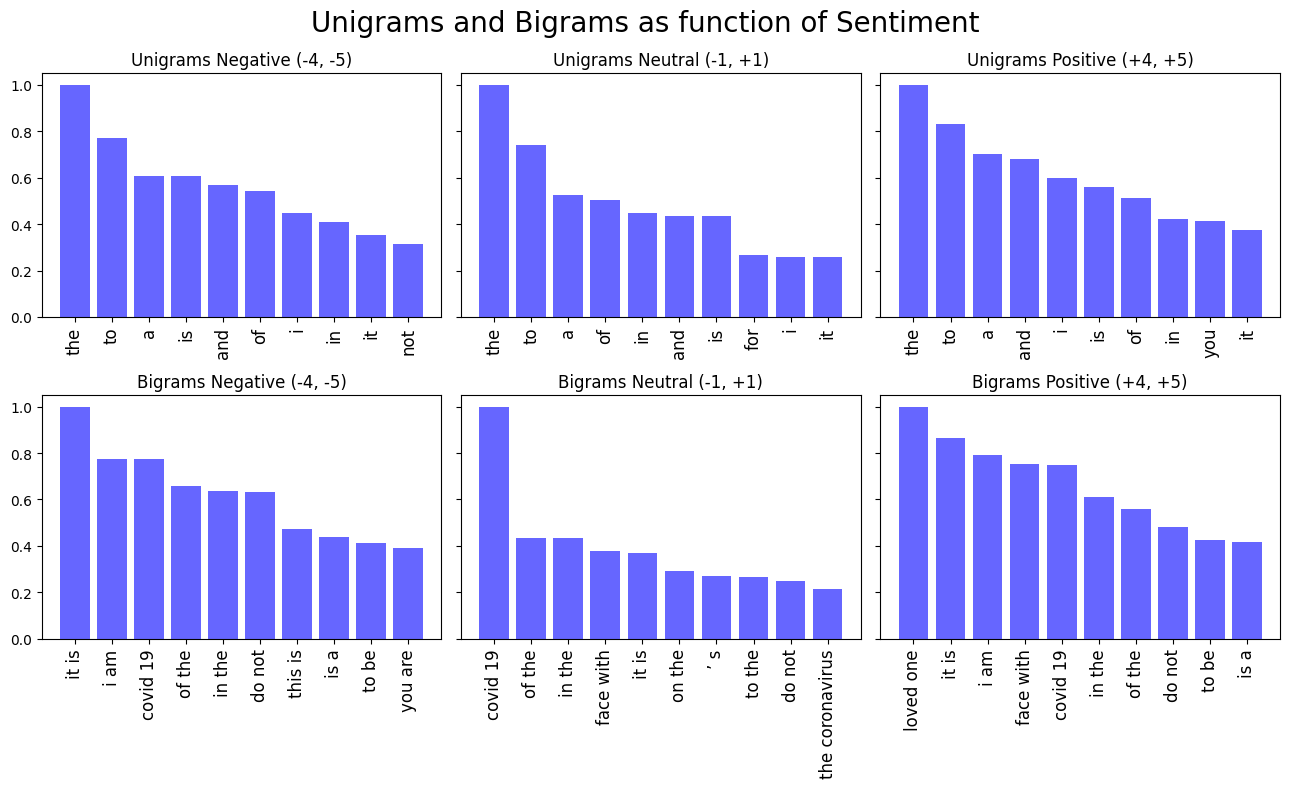

In [25]:
# plot unigram, bigram frequency before and after preprocessing 
fig, ax = plt.subplots(2, 3, sharey='row', figsize=(13,8))

titles = ["Unigrams Negative (-4, -5)", "Unigrams Neutral (-1, +1)", "Unigrams Positive (+4, +5)", \
          "Bigrams Negative (-4, -5)", "Bigrams Neutral (-1, +1)", "Bigrams Positive (+4, +5)"]

grams = [negative_unigrams, neutral_unigrams, positive_unigrams, \
         negative_bigrams, neutral_bigrams, positive_bigrams]
pos = [i for i in range(10)] # position of bars

for i, (title, gram, axis) in enumerate(zip(titles, grams, ax.flatten())):

    words = [gram[j][0][0] for j in range(10)]
    if i > 1:
        words = [' '.join(gram[j][0]) for j in range(10)]
    freq = [gram[j][1] for j in range(10)]
    freq = [x / max(freq) for x in freq]

    axis.bar(pos, freq, align='center', color='b', alpha=0.6)
    axis.set_xticks(pos)
    axis.set_xticklabels(words, fontsize=12, rotation='vertical')
    axis.set_title(title, fontsize=12)

fig.suptitle("Unigrams and Bigrams as function of Sentiment", fontsize=20)
plt.tight_layout()
plt.savefig("uni-bigram-frequencies-sentiment.png")
plt.show()

### Label Distribution

In [ ]:
# get sentiment frequencies
def sentiment_freq(data):

  sentiments = data['Sentiment'].tolist()
  freqs = dict()
  for s in sentiments:
    p, n = s.split()
    p = int(p)
    n = int(n)
    if p in freqs:
      freqs[p] += 1
    else:
      freqs[p] = 1
    if n in freqs:
      freqs[n] += 1
    else:
      freqs[n] = 1

  # turn dictionary into list
  sentlist = list(freqs.items())

  # order by sentiment for plot
  sentlist.sort(key=lambda x: x[0])

  return sentlist

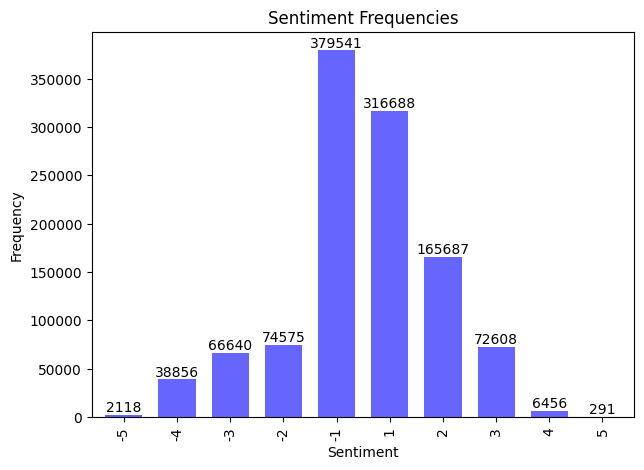

In [ ]:
sentlist = sentiment_freq(data)
sentiment = [str(x[0]) for x in sentlist]
sent_freq = pd.Series([x[1] for x in sentlist])

plt.figure(figsize=(7, 5))
ax = sent_freq.plot(kind="bar", width=0.7, color='b', alpha=0.6)
ax.set_title("Sentiment Frequencies")
ax.set_xlabel("Sentiment")
ax.set_ylabel("Frequency")
ax.set_xticklabels(sentiment)

rects = ax.patches
labels = [str(x[1]) for x in sentlist]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", \
         va="bottom"
    )
plt.savefig("sentiment-distribution.png")
plt.show()

### Word count distribution

In [ ]:
count_positive = [len(x) for x in positive_tweets]
count_negative = [len(x) for x in negative_tweets]
count_neutral = [len(x) for x in neutral_tweets]

In [ ]:
counts = [count_negative, count_neutral, count_positive]

In [ ]:
def plot_wordcount_histogram(ax, counts, title):

  ax.hist(counts, np.arange(0, 100, 1),\
         density=True, color='b', alpha=0.6)
  ax.set_title(title, fontsize=10)
  ax.set_xlabel("Word count")

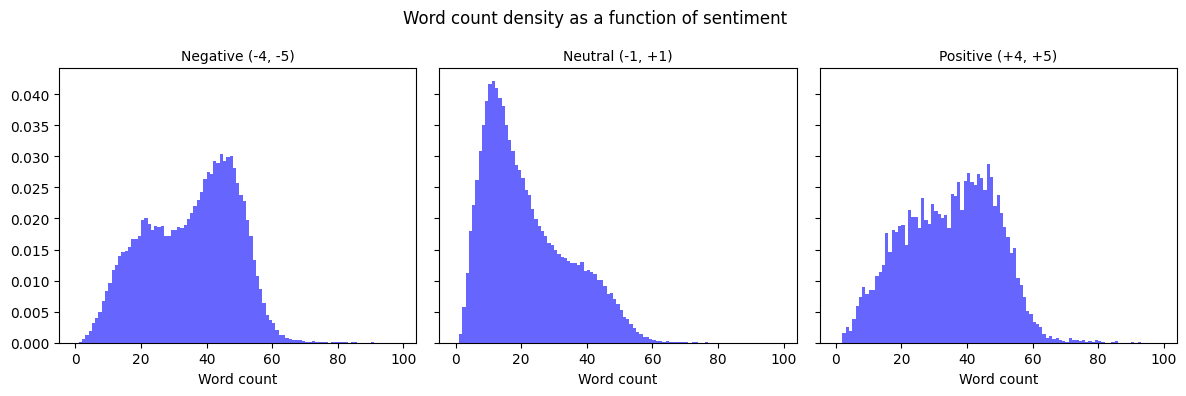

In [ ]:
fig, ax = plt.subplots(1, 3, sharey='row', figsize=(12,4))
titles = ["Negative (-4, -5)", "Neutral (-1, +1)", "Positive (+4, +5)"]
for axis, count, title in zip(ax, counts, titles):
  plot_wordcount_histogram(axis, count, title)
fig.suptitle("Word count density as a function of sentiment")
plt.tight_layout()
plt.savefig("wordcount-densities.png")